# Retrieval API Example


This notebook demonstrates how to use the Retrieval API of the DIAL RAG application.


The retrieval API allows you to retrieve relevant information based on user queries without running the full RAG pipeline. It is useful if the customization of the RAG pipeline by the [configuration](https://dialx.ai/dial_api#operation/configurationDeployment) is not enough for your use case. For example, you may want to use LLM with structured output, or [function calling](https://platform.openai.com/docs/guides/function-calling), or get the [Log probabilities](https://platform.openai.com/docs/api-reference/chat/create#chat_create-logprobs) of the tokens in the response. In this case, you can use the retrieval API to get the relevant documents and then run your custom LLM pipeline on top of them.

This notebook provides a step-by-step example which covers uploading files to DIAL, calling DIAL RAG Retrieval API to retrieve the chunks relevant to the user's question, and demonstrates how to use the results in a custom LLM workflow.

## Setup

Install the dependencies we are going to use in this example:

In [ ]:
!pip install -q openai==1.68.2
!pip install -q requests==2.32.3
!pip install -q python-dotenv==1.0.1

Import the packages we are going to use:

In [1]:
import json
import os

import pandas as pd
import requests
from dotenv import load_dotenv
from IPython.display import HTML, display
from openai import AzureOpenAI

Load `DIAL_URL` and `DIAL_API_KEY` from .env file to access the DIAL RAG API. We need `DIAL_URL` to connect to the DIAL RAG API and `DIAL_API_KEY` to authenticate our requests.

**Note**: we use pre-defined API Key written in `.env` file in this example. For a production applications it is recommended to use per-request key issued by DIAL Core for a single request to your application. For more details, see [Per-request key](https://docs.dialx.ai/platform/core/per-request-keys).

In [2]:
load_dotenv(override=True)

dial_url = os.environ["DIAL_URL"]
api_key = os.environ["DIAL_API_KEY"]

Helper function to upload files to DIAL. See [Uploading file to the DIAL file storage](https://docs.dialx.ai/tutorials/developers/apps-development/multimodality/dial-cookbook/examples/how_to_call_image_to_text_applications#uploading-file-to-the-dial-file-storage) for more details.

In [3]:
bucket = requests.get(
    f"{dial_url}/v1/bucket",
    headers={"Api-Key": api_key},
    timeout=30,
).json()["bucket"]


def upload_file_to_dial(bucket: str, filename: str, content_type: str):
    with open(filename, "rb") as file:
        metadata = requests.put(
            f"{dial_url}/v1/files/{bucket}/data/{os.path.basename(filename)}",
            headers={"Api-Key": api_key},
            files={"file": (os.path.basename(filename), file, content_type)},
            timeout=30,
        ).json()
    return {"type": metadata["contentType"], "url": metadata["url"]}


print(f"Bucket: {bucket}")

Bucket: 6iTkeGUs2CvUehhYLmMYXB


## Retrieval

For this example we will use pdf file with wikipedia article about the Alps and an image file from the test data.

The files should be uploaded to the DIAL before we can use them in the DIAL RAG retrieval API. Let's upload the files to the DIAL:

In [4]:
pdf_file_attachment = upload_file_to_dial(
    bucket, "../tests/data/alps_wiki.pdf", content_type="application/pdf"
)
image_file_attachment = upload_file_to_dial(
    bucket, "../tests/data/test_image.png", content_type="image/png"
)

print(f"PDF file uploaded: {pdf_file_attachment}")
print(f"Image file uploaded: {image_file_attachment}")

PDF file uploaded: {'type': 'application/pdf', 'url': 'files/6iTkeGUs2CvUehhYLmMYXB/data/alps_wiki.pdf'}
Image file uploaded: {'type': 'image/png', 'url': 'files/6iTkeGUs2CvUehhYLmMYXB/data/test_image.png'}


We can use AzureOpenAI client to make a request to the DIAL RAG retrieval API.
For more ways to call the DIAL RAG, you can follow the examples for the ways to call DIAL applications [How to call image-to-text applications](https://docs.dialx.ai/tutorials/developers/apps-development/multimodality/dial-cookbook/examples/how_to_call_image_to_text_applications) and adapt the code accordingly.

To make a retrieval request, you need to specify `request.type` as `retrieval` in the `custom_fields.configuration`.

In [5]:
question = "What is the best known alpine plant?"

# Initialize the Azure OpenAI client
client = AzureOpenAI(
    azure_endpoint=dial_url,
    api_key=api_key,
    api_version="2024-10-21",
)

attachments = [
    pdf_file_attachment,
    image_file_attachment,
]

# Send a retrieval request
response = client.chat.completions.create(
    model="dial-rag",
    messages=[
        {
            "role": "user",
            "content": question,
            "custom_content": {"attachments": attachments},
        }
    ],
    extra_body={
        "custom_fields": {
            "configuration": {
                "request": {
                    "type": "retrieval",
                }
            }
        }
    },
    stream=False,  # We can set stream=True, but we will need to assemble the response JSON from streamed chunks
)

## Retrieval results

The retrieval result contains the attachment with type `application/vnd.aidial.rag.retrieval-results+json`. This attachment contains the retrieval results in JSON format.

In [6]:
response_attachments = response.choices[0].message.custom_content["attachments"]
retrieval_results_attachment = next(
    (
        attachment
        for attachment in response_attachments
        if attachment["type"]
        == "application/vnd.aidial.rag.retrieval-results+json"
    ),
    None,
)

retrieval_results_json = json.loads(retrieval_results_attachment["data"])

chunks = retrieval_results_json["chunks"]
images = retrieval_results_json.get("images", [])

The retrieval results contain the list of chunks in the order of relevance. Additionally, it contains the list of images associated with the retrieved.

Let's look at the most relevant chunk, which is the first one in the list:

In [7]:
print(json.dumps(chunks[0], indent=2))

{
  "attachment_url": "files/6iTkeGUs2CvUehhYLmMYXB/data/alps_wiki.pdf",
  "source": {
    "url": "files/6iTkeGUs2CvUehhYLmMYXB/data/alps_wiki.pdf#page=11",
    "display_name": "data/alps_wiki.pdf"
  },
  "text": "At these higher altitudes, the plants tend to form isolated cushions. In the Alps, several species of flowering plants have been recorded above 4,000 m (13,120 ft), including Ranunculus glacialis, Androsace alpina and Saxifraga biflora. The Eritrichium nanum, commonly known as the King of the Alps, is the most elusive of the alpine flowers, growing on rocky ridges at 2,600 to 3,750 m (8,530 to 12,303 ft).[60] Perhaps the best known of the alpine plants is the Edelweiss which grows in rocky",
  "page": {
    "number": 11,
    "image_index": 0
  }
}


Let's display top 5 chunks from the retrieval results as a table using Pandas:

source,page,text,image
data/alps_wiki.pdf,Page 11,"At these higher altitudes, the plants tend to form isolated cushions. In the Alps, several species of flowering plants have been recorded above 4,000 m (13,120 ft), including Ranunculus glacialis, Androsace alpina and Saxifraga biflora. The Eritrichium nanum, commonly known as the King of the Alps, is the most elusive of the alpine flowers, growing on rocky ridges at 2,600 to 3,750 m (8,530 to 12,303 ft).[60] Perhaps the best known of the alpine plants is the Edelweiss which grows in rocky",
data/alps_wiki.pdf,Page 11,"Flora\n\nThirteen thousand species of plants have been identified in the Alpine regions.[3] Alpine plants are grouped by habitat and soil type which can be limestone or non-calcerous. The habitats range from meadows, bogs, woodland (deciduous and coniferous) areas to soilless scree and moraines, and rock faces and ridges.[6] A natural vegetation limit with altitude is given by the presence of the chief deciduous trees—oak, beech, ash and sycamore maple. These do not reach exactly to the same elevation, nor are they often found growing together; but their upper limit corresponds accurately enough to the change from a temperate to a colder climate that is further proved by a change in the presence of wild herbaceous vegetation. This limit usually lies about 1,200 m (3,940 ft) above the sea on the north side of the Alps, but on the southern slopes it often rises to 1,500 m (4,920 ft), sometimes even to 1,700 m (5,580 ft).[55]",
data/alps_wiki.pdf,Page 11,"Stemless gentian (Gentiana acaulis)\n\nAbove the forestry, there is often a band of short pine trees (Pinus mugo), which is in turn superseded by Alpenrosen, dwarf shrubs, typically Rhododendron ferrugineum (on acid soils) or Rhododendron hirsutum (on alkaline soils).[56] Although the Alpenrose prefers acidic soil, the plants are found throughout the region.[6] Above the tree line is the area defined as ""alpine"" where in the alpine meadow plants are found that have adapted well to harsh conditions of cold temperatures, aridity, and high altitudes. The alpine area fluctuates greatly because of regional fluctuations in tree lines.[57]",
data/alps_wiki.pdf,Page 11,"Alpine plants such the Alpine gentian grow in abundance in areas such as the meadows above the Lauterbrunnental. Gentians are named after the Illyrian king Gentius, and 40 species of the early- spring blooming flower grow in the Alps, in a range of 1,500 to 2,400 m (4,921 to 7,874 ft).[58] Writing about the gentians in Switzerland D. H. Lawrence described them as ""darkening the day-time, torch- like with the smoking blueness of Pluto's gloom.""[59] Gentians tend to ""appear"" repeatedly as the spring blooming takes place at progressively later dates, moving from the lower altitude to the higher altitude meadows where the snow melts much later than in the valleys. On the highest rocky ledges the spring flowers bloom in the summer.[6]",
data/alps_wiki.pdf,Page 12,"areas and can be found at altitudes as low as 1,400 m (4,593 ft) and as high as 3,400 m (11,155 ft).[6] The plants that grow at the highest altitudes have adapted to conditions by specialization such as growing in rock screes that give protection from winds.[61]\n\nThe extreme and stressful climatic conditions give way to the growth of plant species with secondary metabolites important for medicinal purposes. Origanum vulgare, Prunella vulgaris, Solanum nigrum and Urtica dioica are some of the more useful medicinal species found in the Alps.[62]",

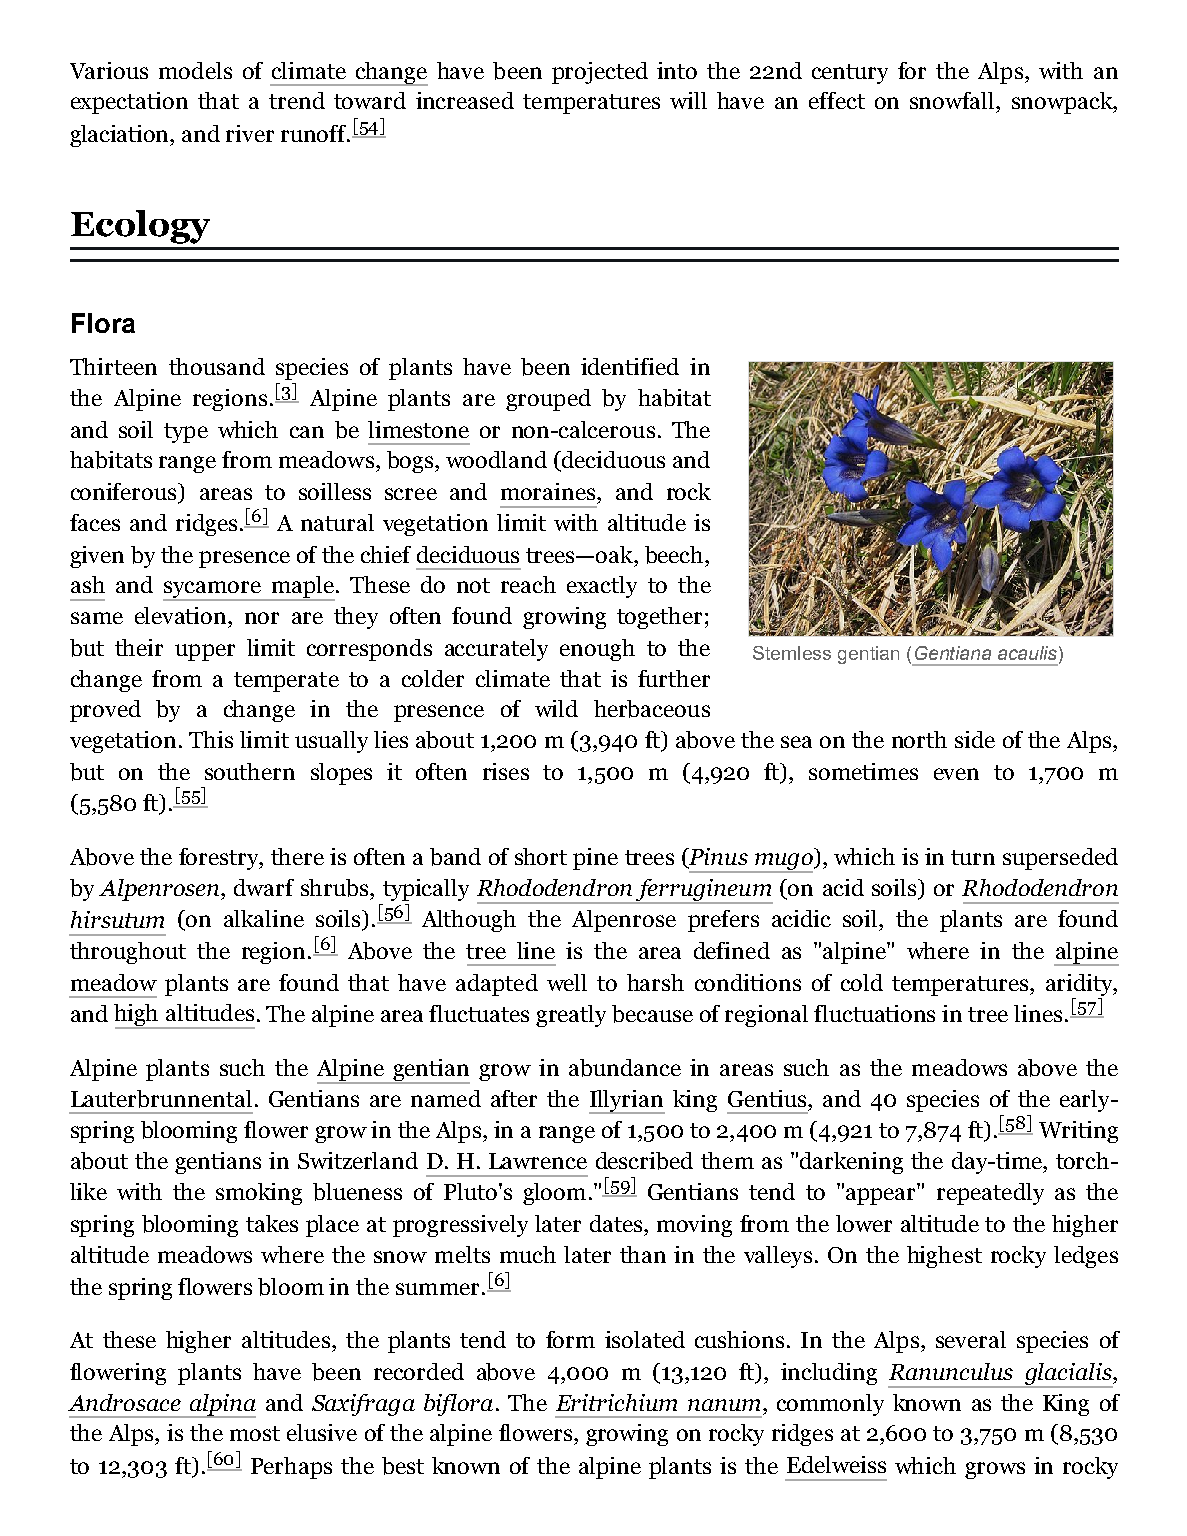
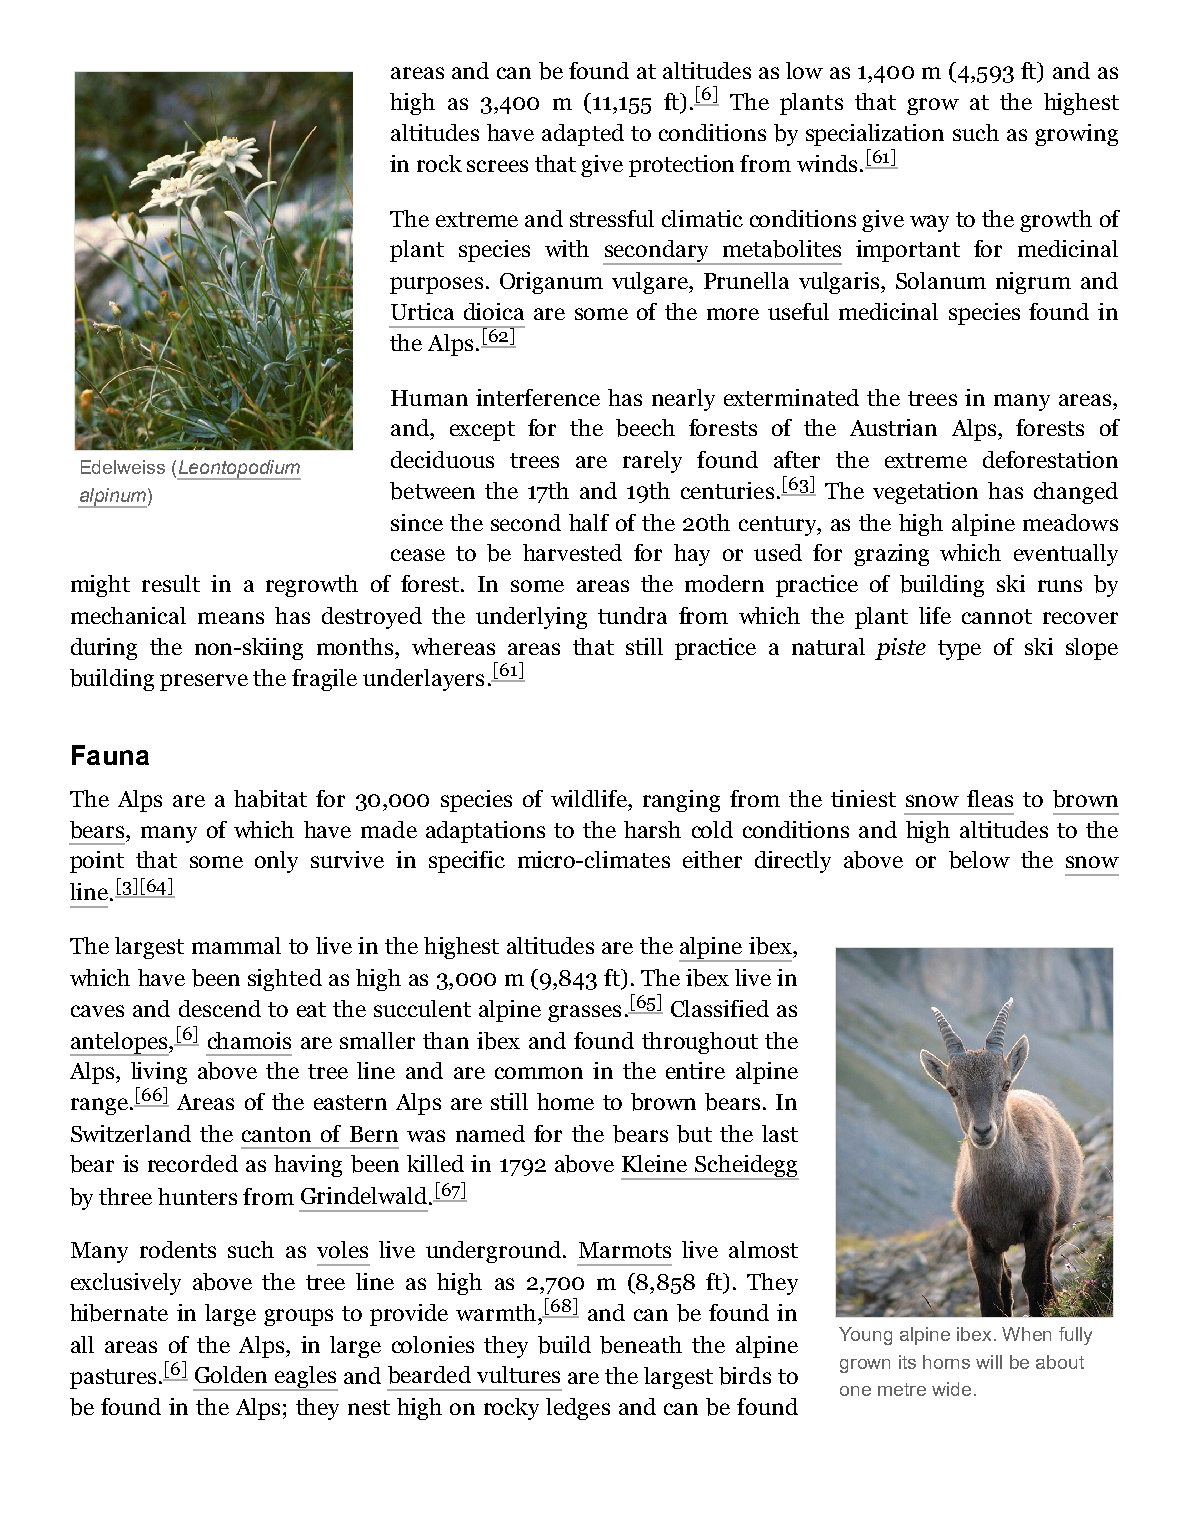

In [8]:
chunks_df = pd.DataFrame(chunks).head(n=5)
table_df = pd.DataFrame(
    {
        "source": chunks_df["source"].apply(
            lambda source: f'<a href="{source["url"]}">{source["display_name"]}</a>'
        ),
        "page": chunks_df["page"].apply(
            lambda page: f"Page {page.get('number', 'N/A')}"
        ),
        "text": chunks_df["text"],
        "image": chunks_df["page"].apply(
            lambda page: f'<img src="data:image/png;base64,{images[page["image_index"]]["data"]}"/>'
            if page.get("image_index") is not None
            else ""
        ),
    }
)

display(HTML(table_df.to_html(escape=False, index=False)))

# Using the retrieval results in LLM request

We can use the retrieval results to make a request to LLM to have custom generation step in our custom RAG application.

Let's make a simple RAG using the retrieved chunks which will use `gpt-4o-mini-2024-07-18` model and JSON response format.
We need to use [Array of content parts](https://platform.openai.com/docs/api-reference/chat/create#chat_create-messages) variant for `message.content` to send the page images to the model.

In [9]:
content = [
    {"type": "text", "text": "Here are the results of the RAG retrieval:"}
]

for i, chunk in enumerate(chunks):
    content.append(
        {"type": "text", "text": f"Chunk {i + 1} text: ```{chunk['text']}```"}
    )
    page_image_index = chunk.get("page", {}).get("image_index")
    if page_image_index is None:
        continue

    content.append({"type": "text", "text": f"Chunk {i + 1} image:"})
    content.append(
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{images[page_image_index]['data']}",
            },
        }
    )

content.append(
    {
        "type": "text",
        "text": f"Answer the question '{question}'. "
        "Write response in JSON format with 'answer' field for the answer and "
        "'citation' field for the citation of from the retrieved chunks.",
    }
)


response = client.chat.completions.create(
    model="gpt-4o-mini-2024-07-18",
    messages=[
        {
            "role": "user",
            "content": content,
        }
    ],
    stream=False,
    response_format={"type": "json_object"},
)

print(response.choices[0].message.content)

{
  "answer": "The best known alpine plant is the Edelweiss.",
  "citation": "Chunk 1 text"
}
